In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import tensorflow as tf
from tensorflow import keras

In [2]:
end_date = datetime.now().date() - timedelta(days=15)
start_date = datetime.now().date() - timedelta(days=59)

end_date1 = datetime.now().date()
start_date1 = datetime.now().date() - timedelta(days=14)

In [3]:
df = yf.download('ITC.NS', interval='30m', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-03-16 09:30:00,379.149994,380.299988,378.149994,379.350006,379.350006,546945
2023-03-16 10:00:00,379.350006,380.000000,378.299988,380.000000,380.000000,500615
2023-03-16 10:30:00,380.000000,380.500000,379.399994,380.000000,380.000000,750547
2023-03-16 11:00:00,380.000000,380.450012,379.250000,379.250000,379.250000,419573
2023-03-16 11:30:00,379.250000,379.799988,378.549988,379.149994,379.149994,461125


data=data.reset_index()

In [5]:
df.reset_index(inplace=True)

dataDF= requests.get("http://127.0.0.1:8000/api/query/ITC.NS/") 

dataD= dataDF.json()

df= pd.read_json(dataDF.json())

In [6]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-03-16 09:30:00,379.149994,380.299988,378.149994,379.350006,379.350006,546945
1,2023-03-16 10:00:00,379.350006,380.000000,378.299988,380.000000,380.000000,500615
2,2023-03-16 10:30:00,380.000000,380.500000,379.399994,380.000000,380.000000,750547
3,2023-03-16 11:00:00,380.000000,380.450012,379.250000,379.250000,379.250000,419573
4,2023-03-16 11:30:00,379.250000,379.799988,378.549988,379.149994,379.149994,461125


In [7]:
df.dtypes

Datetime     datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
trainSet = df.iloc[:, 1:2].values
scaler = MinMaxScaler(feature_range=(0, 1))
trainingSetScaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

xTRAIN = []
yTRAIN = []
for i in range(60, len(trainingSetScaled)):
    xTRAIN.append(trainingSetScaled[i - 60:i, 0])
    yTRAIN.append(trainingSetScaled[i, 0])
xTRAIN, yTRAIN = np.array(xTRAIN), np.array(yTRAIN)

In [9]:
xTRAIN = np.reshape(xTRAIN, newshape=(xTRAIN.shape[0], xTRAIN.shape[1], 1))
regressor = keras.models.Sequential([
    keras.layers.LSTM(units=64, return_sequences=True, input_shape=(xTRAIN.shape[1], 1)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(units=50, return_sequences=True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(units=50),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1)
    ])

In [10]:
xTRAIN.shape

(276, 60, 1)

In [11]:
regressor.compile(optimizer= 'adam', loss= keras.losses.mean_squared_error)
regressor.fit(x= xTRAIN, y=yTRAIN, batch_size= 32, epochs= 5)

Epoch 1/5
9/9 [==============================] - 11s 50ms/step - loss: 0.0843
Epoch 2/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0199
Epoch 3/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0102
Epoch 4/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0085
Epoch 5/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0053


In [12]:
testDF = yf.download('ITC.NS', interval='30m', start=start_date1, end=end_date1)
realSP= testDF['Close'].values
dfTotal= pd.concat((df['Open'], testDF['Open']), axis=0)
modelInp= dfTotal[len(dfTotal)-len(testDF)-60:].values
modelInp= modelInp.reshape(-1,1)
modelInp= scaler.transform(modelInp)

xTEST= []
for i in range(60, len(modelInp)):
    xTEST.append(modelInp[i-60:i, 0])
xTEST= np.array(xTEST)
xTEST= np.reshape(xTEST, newshape= (xTEST.shape[0], xTEST.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


In [13]:
import matplotlib.pyplot as plt

4/4 [==============================] - 2s 34ms/step


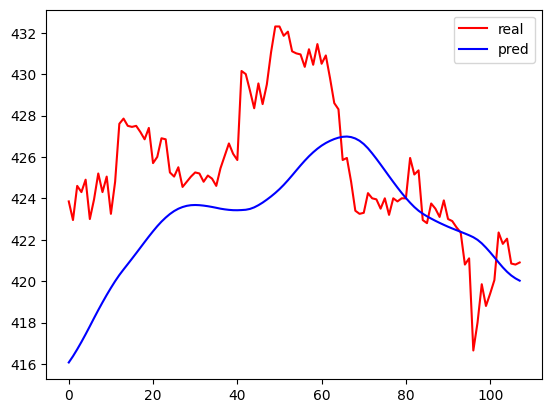

In [14]:
pred= regressor.predict(xTEST)
pred= scaler.inverse_transform(pred)
plt.plot(realSP, color= 'r', label= 'real')
plt.plot(pred, color= 'b', label= 'pred')
plt.legend()
plt.show()

In [15]:
realData= [modelInp[len(modelInp)+1-60:len(modelInp+1), 0]]
realData= np.array(realData)
realData= np.reshape(realData, newshape=(realData.shape[0], realData.shape[1], 1))
prediction= regressor.predict(realData)
prediction= scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 875ms/step
[[419.93652]]


In [16]:
realData.shape

(1, 59, 1)

In [17]:
realSP.shape

(108,)